In [2]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta

#Plotting
import matplotlib.pyplot as plt
%matplotlib widget
import matplotlib.colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import vector_tools as vt
import Plot_tools as pt

# Data Overview

### Types of Data

The study consisted of deploying a mooring within the Stillwater Kelp forest from July 22nd to September 8th:
- Central mooring was dropped at a location with approximately 10 meters of continuous kelp coverage in all directions
    - 36.56196, -121.94176
- Maximum water depth was 38ft (11.6m), with an average of 34ft (10.4m)
- HOBO temperature logger pro V2's attached to a taut line suspended by subsurface buoy at the mooring weight
    - 7/21/2022 - 9/8/2022
    - 36.56196, -121.94176 (same as central mooring weight
    - Loggers placed along the line at 9.7, 9.4, 9.1, 8, 6, 4, and 2 meters below the surface
    - Each logger sampled continuously at 1 minute intervals
    - Note: loggers from 4-9.7m all out of water from '2022-08-20T16:59:00.000000000'-'2022-08-23T13:20:00.000000000'
- Teledyne RDI ADCP platform placed within relatively clear sand patch within the forest 
    - First deployment
        - 7/21/2022 - 8/14/2022
        - 36.56194210195769, -121.94175918358738
        - Sampled continuously, 1-minute long ensembles averaging 70 pings/minute
        - Bins start at 1m off bottom with .25m spacing between them
    - Second deployment
        - 8/23/2022 - 8/30/2022
        - 36.56194989498659, -121.9417662787946
        - Sampled for 20 minute bursts every hour at 1Hz averaging 12 subpings/second (mode 12)
- Nortek Vector ADV placed in tripod on the seafloor near kelp clusters, velocity transducers were 1m off the floor
    - Sampled for 20 minute bursts every hour at 32Hz
    - 36.56195999999164, -121.94174126537672 (wasn't moved during retrieval and redeployment)
    - First deployment
        - 8/2/2022 - 8/11/2022
    - Second deployment
        - 8/15/2022 - 8/30/2022  
- Monterey Bay Aquarium Research Institute M1 Mooring data (7/21/2022 - 9/9/2022)
- NOAA National Buoy Data Center Statino 46042 (July - September)
- Radial kelp surveys conducted via SCUBA 
    - Each survey consisted of 8 4m x 10m transects run at 0, 45, 90, 135, 180, 225, 270, 315 degree headings
    - Each individual "stipe bundle" within the 4m diameter had its distance and heading on the transect, as well as its diameter recorded
    - A "stipe bundle" is subjectively defined as a any tightly spaced cluster of stipes
        - This sometimes includes multiple kelp individuals that have grown so close together that they are indistinguishable from a single shape

### SWC Mooring Layout

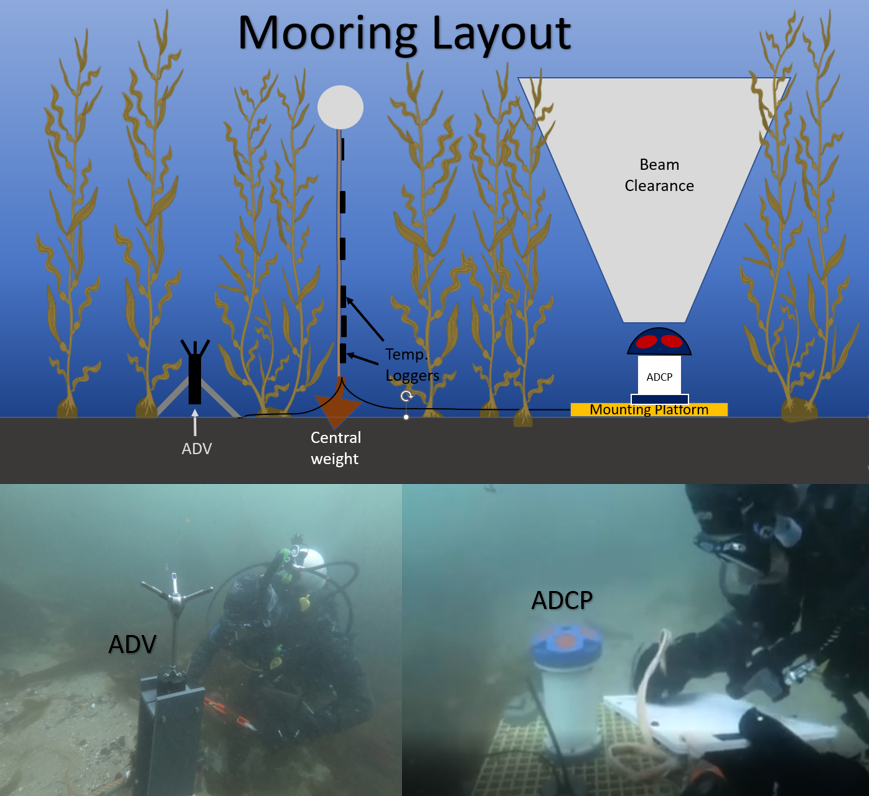

### Import data

In [3]:
# Temperature data
temp = xr.open_dataset('Temperature/temp_final.nc')

# ADCP data
adcp1 = xr.open_dataset('ADCP/adcp1_qc.nc')
adcp2 = xr.open_dataset('ADCP/adcp2_qc.nc')

# ADV data
adv1 = xr.open_dataset('ADV/adv1IntAvg.nc')
adv2 = xr.open_dataset('ADV/adv2IntAvg.nc')

# M1 data
m1_ns = xr.open_dataset('M1/m1_ns.nc')
m1_ew = xr.open_dataset('M1/m1_ew.nc')
m1_temp = xr.open_dataset('M1/m1_temp.nc')
m1_wind = xr.open_dataset('M1/m1_wind.nc')

# NBDC 46042 data
ndbc_2022 = xr.open_dataset('46042_Buoy/ndbc_2022.nc')

# Kelp survey data

# Description of Stillwater Cove and Kelp Forest Site

Stillwater Cove (SWC) is a small inlet located at Northern tip of Carmel Bay between Pescadero Point and Arrowhead point. SWC is directly east of Pebble beach, and the two beaches are seperated by a shallow-water, south-running ridge that culminates in a protruding spire of rocks at the offshore boundary known as the Pescadero Rocks. Pesacdero Point, Arrowhead Point, and the Pescadero Rocks all shield SWC from the typical Northwesterly winds that Monterey Bay experiences, but not Westerly or Southerly winds.

From the SWC acccess pier to Pescadero Rocks, there is a shallow water water ridge with rocky substrate that allows a kelp forest to thrive. While this kelp forest is vast and healthy, this site was not chosen because it resides at a range of 2-6 meters in depth and is blocked from offshore waters by the Pescardero Rocks. Measurements of turbulence would likely be too influenced by the bottom boundary layer and surface gravity waves, while the Pescadero Rocks may shelter the site from important offshore processes that this study is interested in analysing. On the Eastern side of SWC, there is another forest that extends from the beach to the tip of Arrowhead point. This forest resides from about 2-11 meters in depth and is more exposed to the offshore waters than the Western site. The topography and rugosity of the forest is also more suitable for the acoustic instruments, with flat and sandy patches of seafloor surounded by rocky substrate that was shorter than the instruments themselves (< 1m).

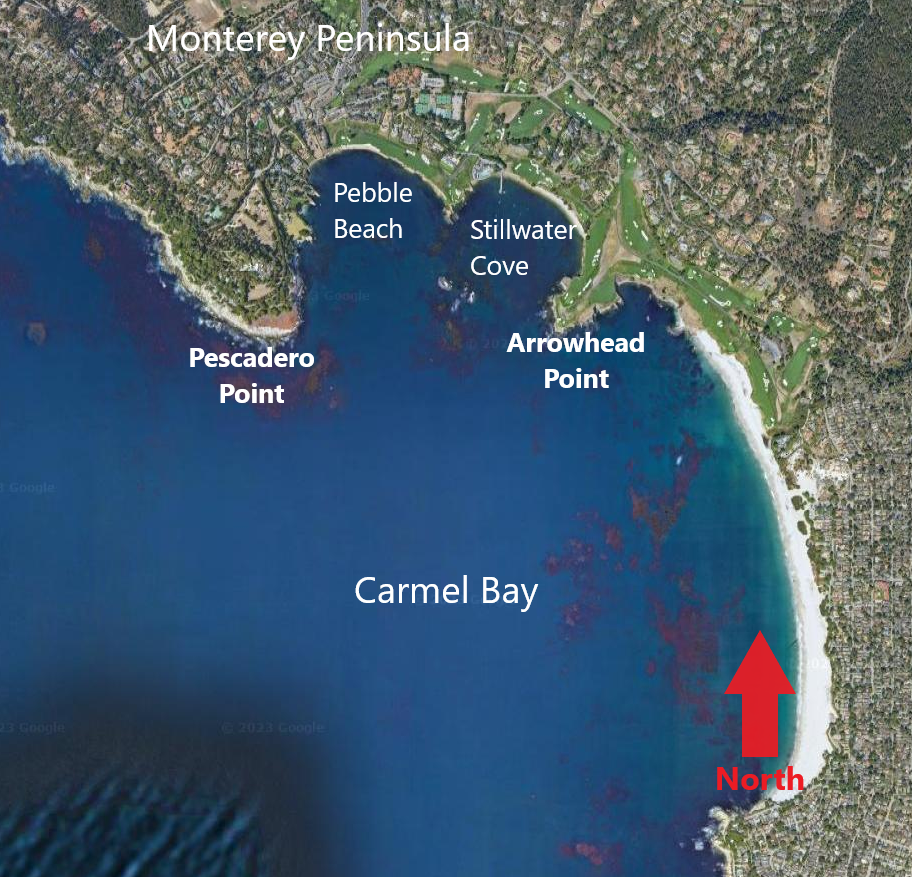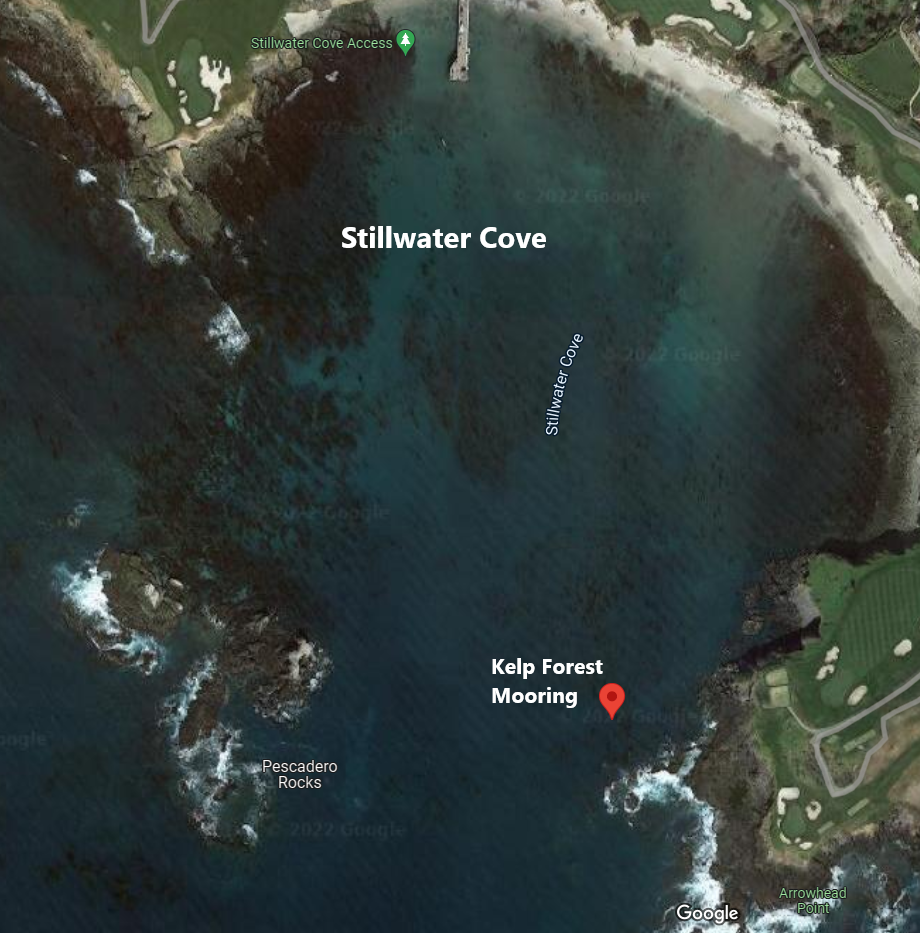

# Exploring SWC Mooring Data

In [3]:
#Plot temperature profile with currents speeds from ADCP and ADV over each of the time series segments

#20-minute averaging interval smooths noise from the data while still resolving important cooling events
rsamp = '60Min'

#Segment 1 (Temperature and adcp data, no adv)
dep1TS = '2022-07-22T00:00:00.000000000' #Start time
dep1TE = '2022-08-02T11:39:00.000000000' #End time

#Segment 2 (Temperature, adcp, and adv data)
dep2TS = '2022-08-02T11:40:00.000000000'
dep2TE = '2022-08-10T23:59:00.000000000'

#Segment 3 (Temperature and adv data, no adcp)
dep3TS = '2022-08-15T08:40:00.000000000'
dep3TE = '2022-08-23T12:00:00.000000000'

#Segment 4 (Temperature, adcp, and adv data)
dep4TS = '2022-08-23T12:40:00.000000000'
dep4TE = '2022-08-30T11:00:00.000000000'

### Hydrodynamic overview
- Temperature profile time series
- Depth averaged ADCP time series
- ADV time series
- Current direction for both
- Averaged over 1-hour

Plotting temperature


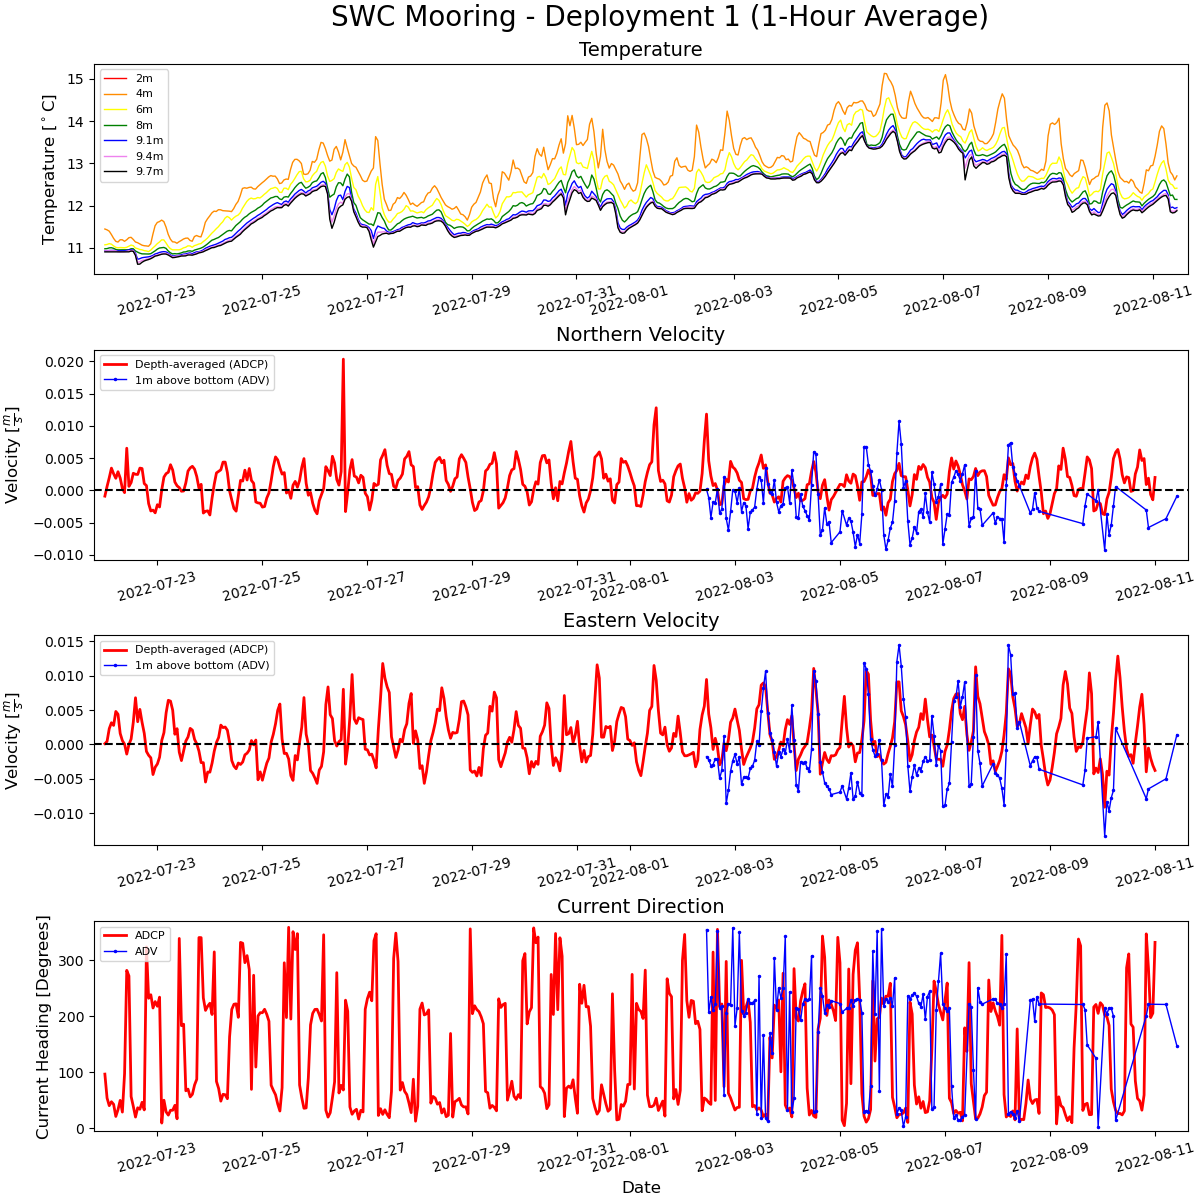

In [134]:
#Deployment 1
pt.overview_plot(temp, adcp1, adv1, startTime = dep1TS, endTime = dep2TE, supTitle = 'SWC Mooring - Deployment 1 (1-Hour Average)', resample = rsamp, saveFig = 'Plots/SWC_overview_dep1.png')

Plotting temperature


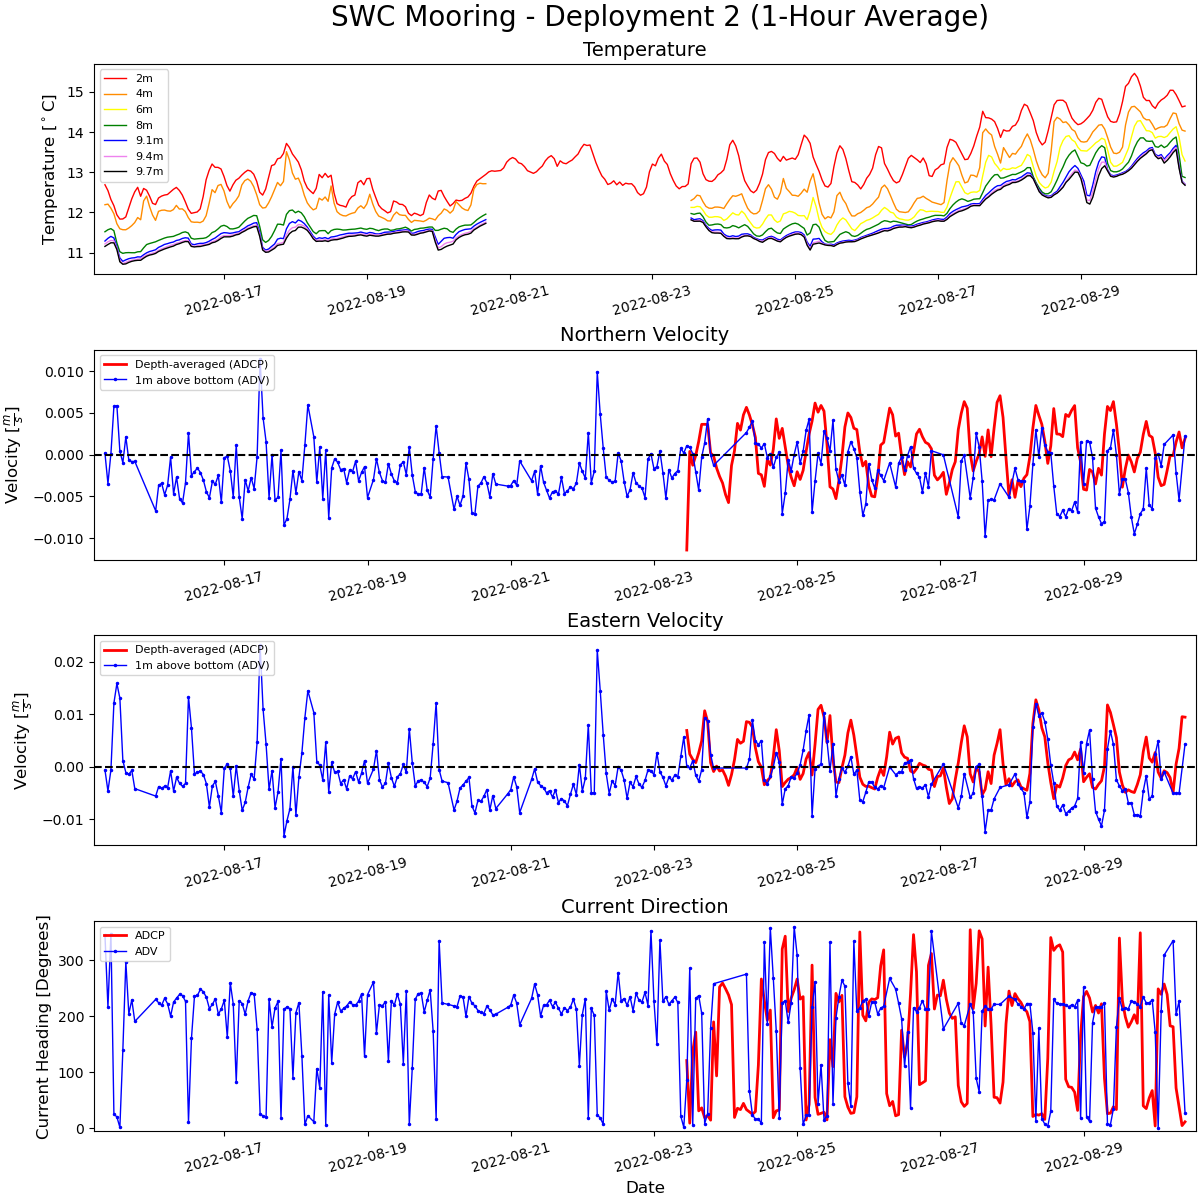

In [136]:
#Deployment 2
pt.overview_plot(temp, adcp2, adv2, startTime = dep3TS, endTime = dep4TE, supTitle = 'SWC Mooring - Deployment 2 (1-Hour Average)', resample = rsamp, saveFig = 'Plots/SWC_overview_dep2.png')

### ADCP profiles
- Temperature profile time series
- ADCP profile time series
- Height cutoff at 8m since kelp canopy disturbs data
- Water height from ADCP pressure sensor
- Averaged over 1-hour

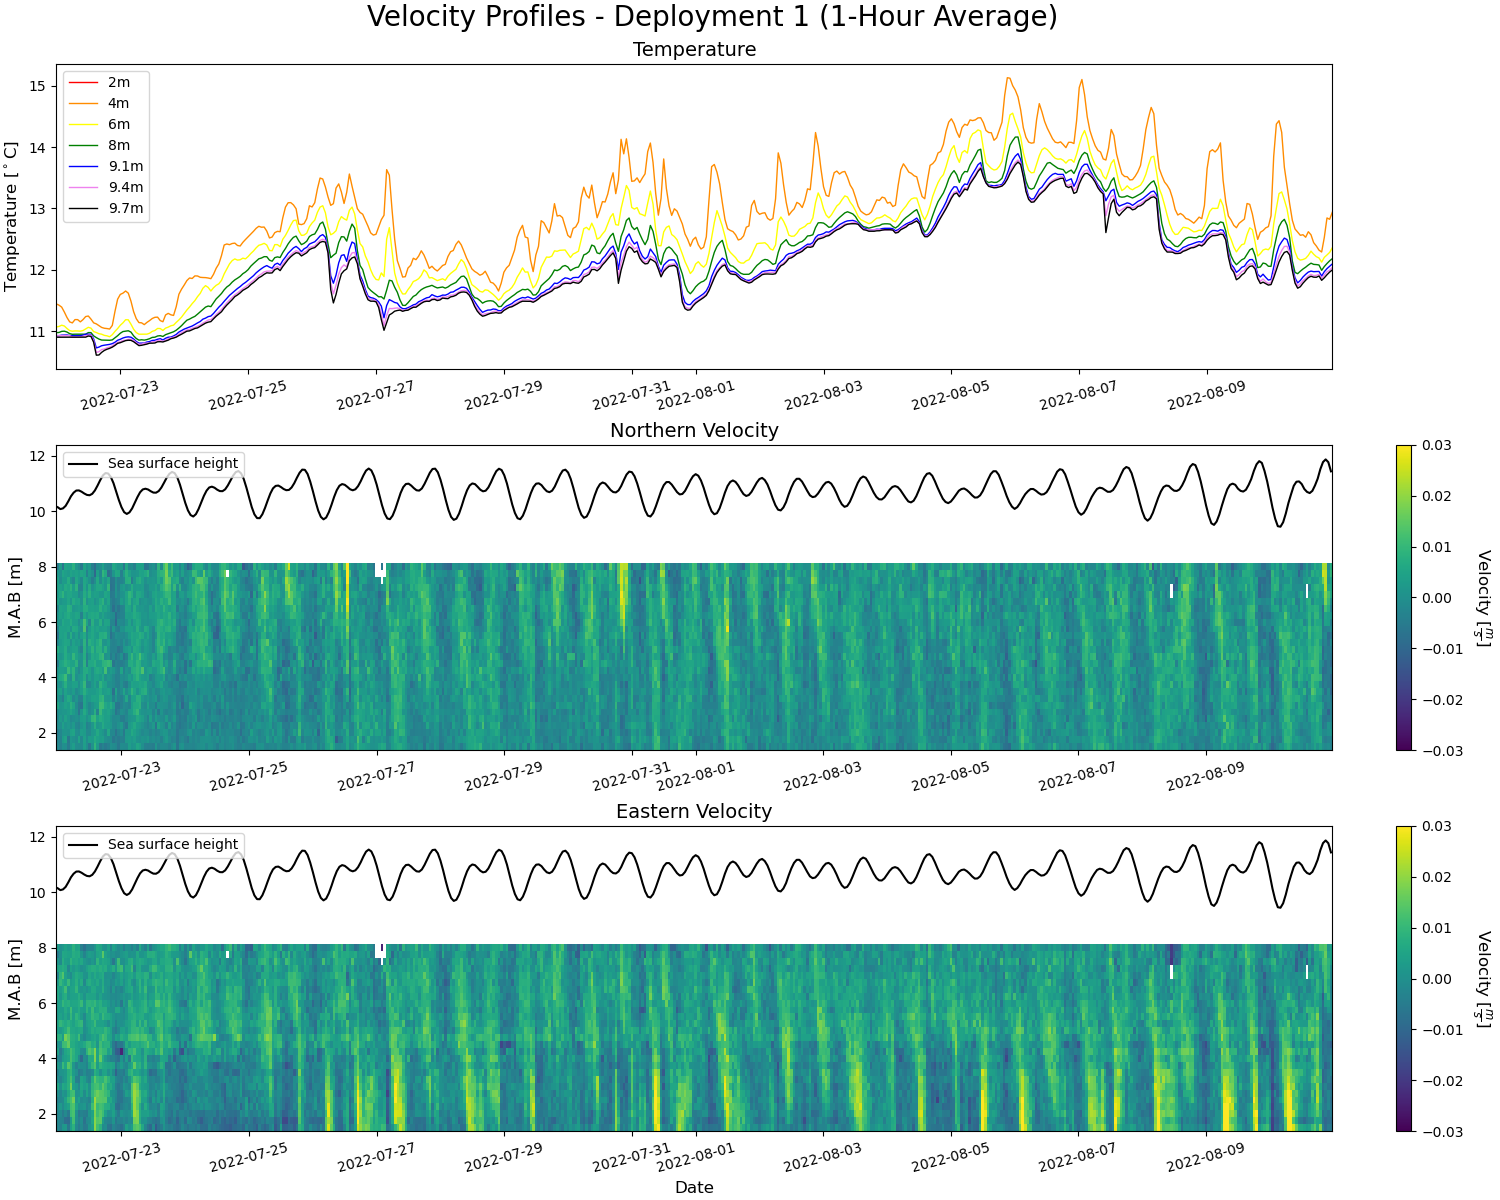

In [14]:
adcp_profile_plot(temp, adcp1, .03, -.03, binNums = [1,28], tStart = dep1TS, tEnd = dep2TE,
                          rSamp = '60Min', flagCutoff = 3, flagPlot = False, supTitle = 'Velocity Profiles - Deployment 1 (1-Hour Average)', saveFig = 'Plots/velocity_profiles_dep1.png')

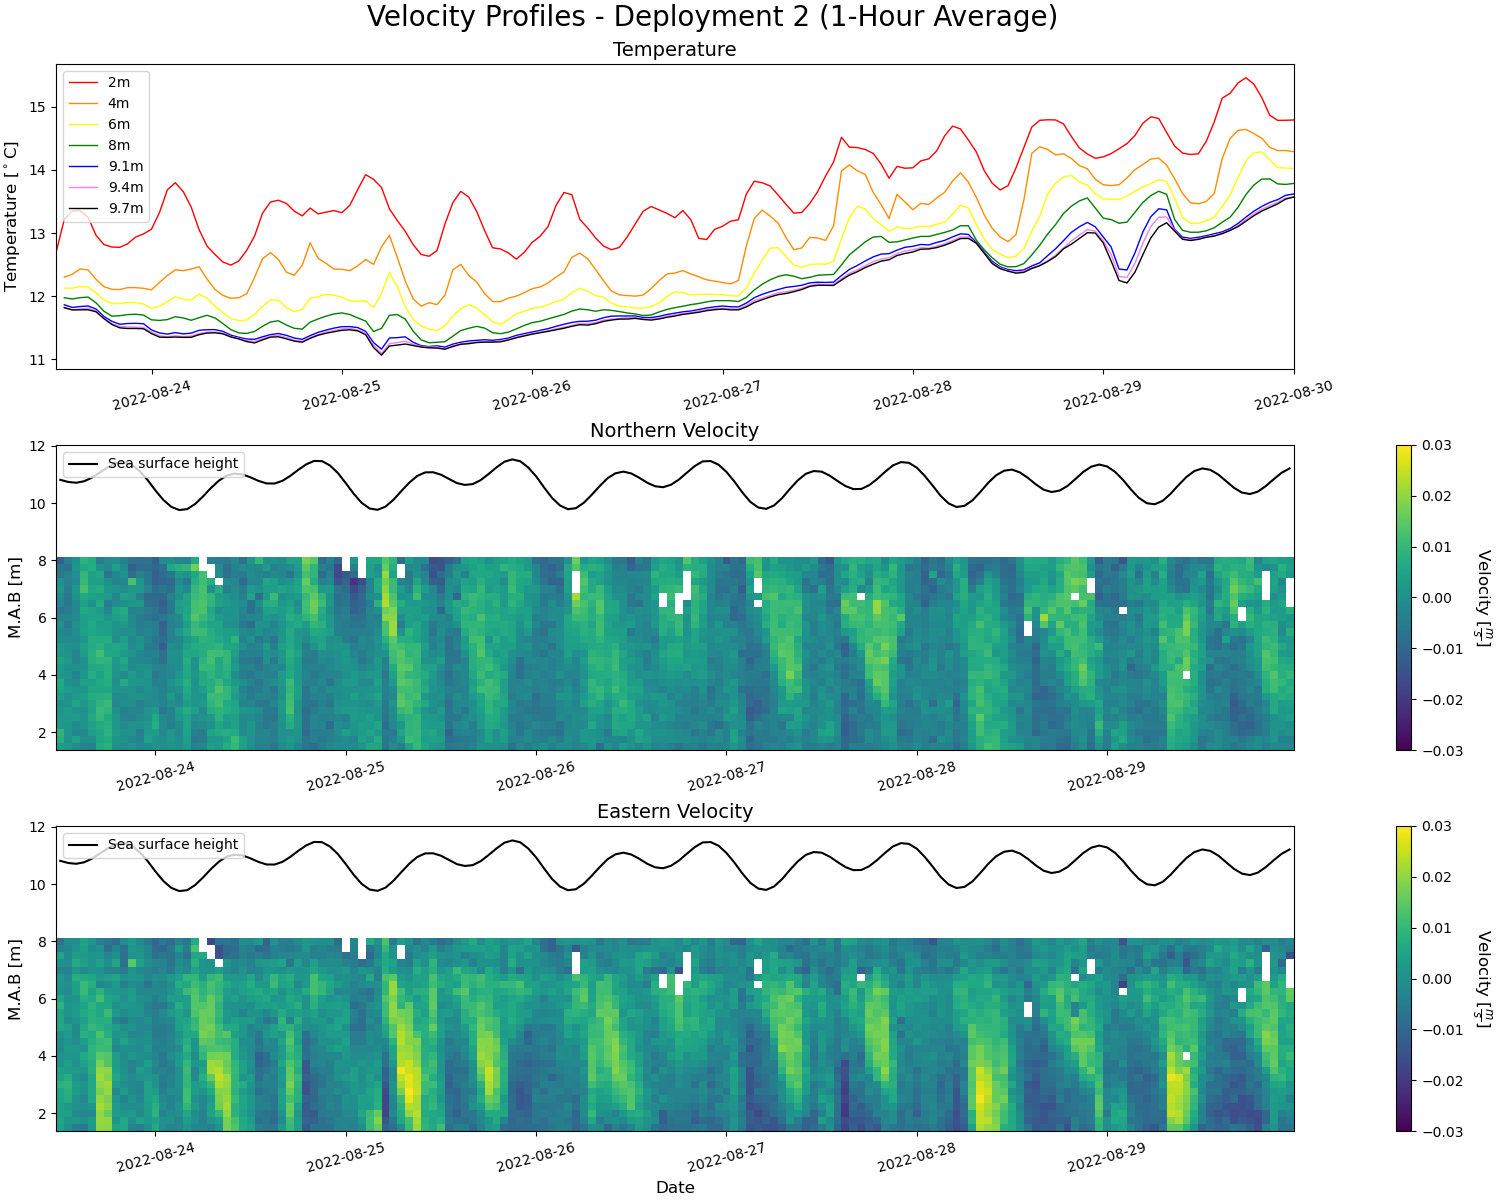

In [19]:
tStart = '2022-08-23T12:00:00.000000000'
tEnd = '2022-08-30T00:00:00.000000000'
adcp_profile_plot(temp, adcp2, .03, -.03, binNums = [1,28], tStart = tStart, tEnd = tEnd,
                          rSamp = '60Min', flagCutoff = 3, flagPlot = False, supTitle = 'Velocity Profiles - Deployment 2 (1-Hour Average)', saveFig = 'Plots/velocity_profiles_dep2.png')

### Effect of winds on temperature

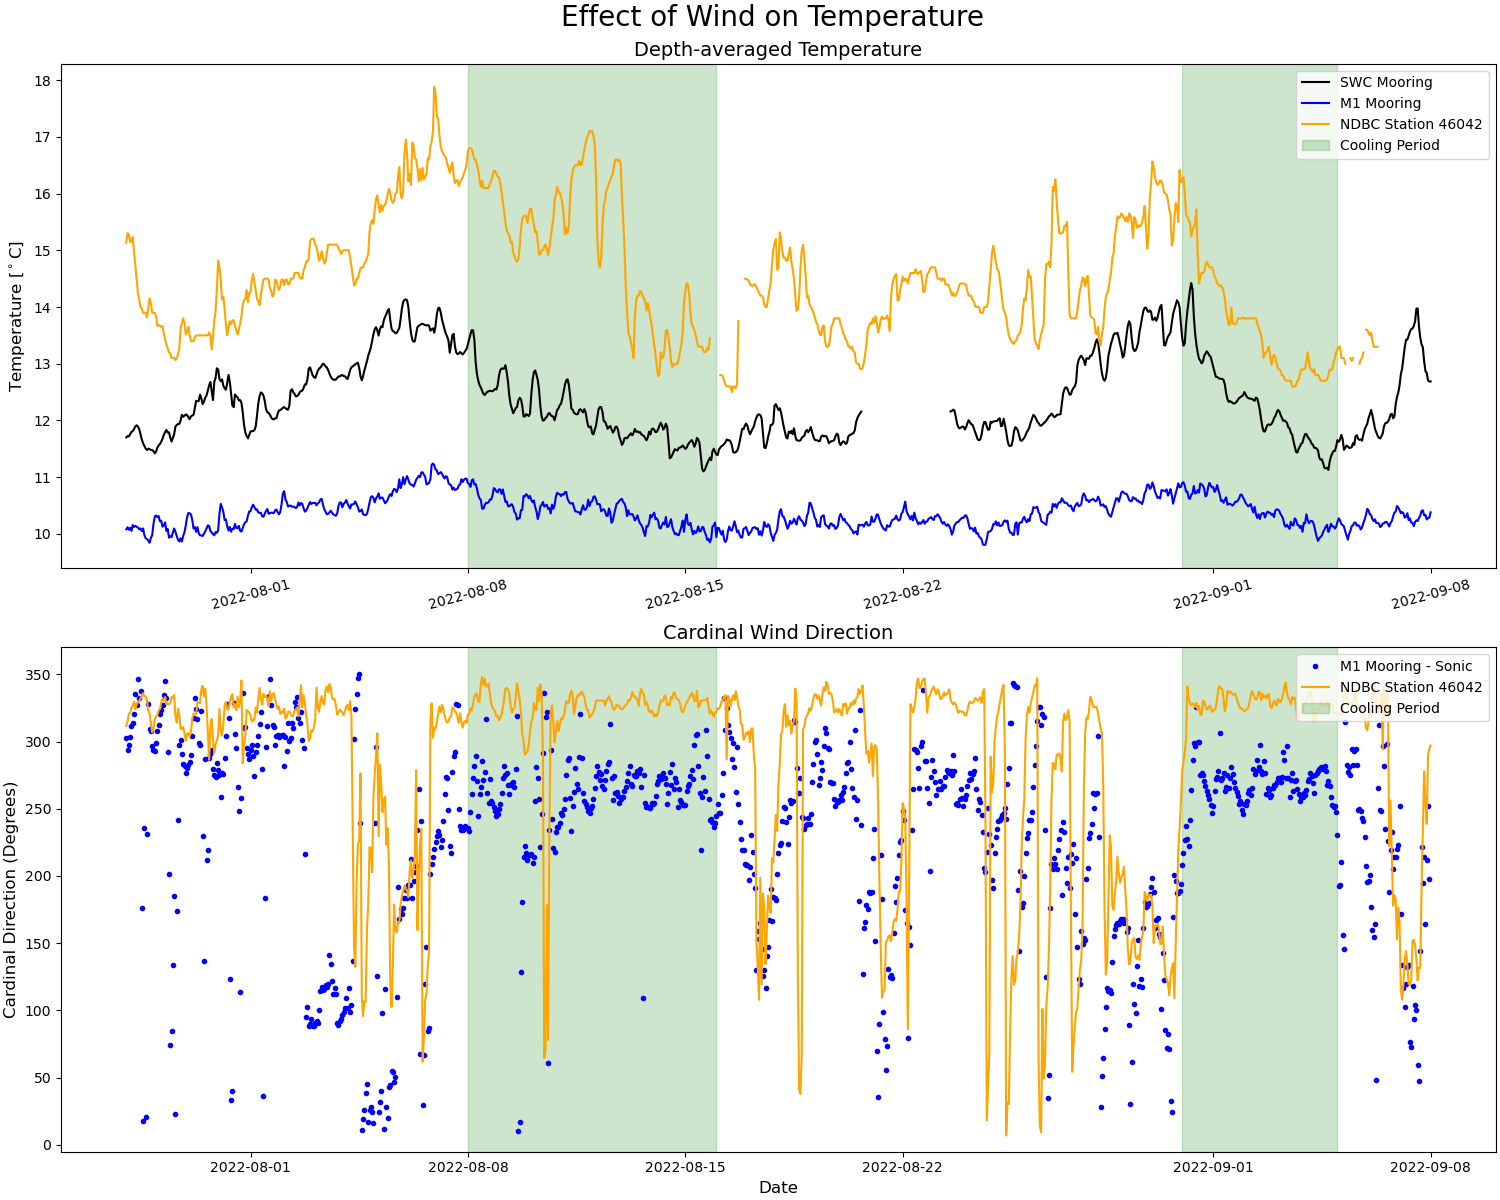

In [43]:
tStart = '2022-07-28T00:00:00.000000000'
tEnd = '2022-09-08T00:00:00.000000000'
rSamp = '60Min'

# create figure and axis objects with subplots()
fig, axs = plt.subplots(2,1,constrained_layout=True, figsize = (15,12))

fig.suptitle('Effect of Wind on Temperature', x = .515, size = 20)

Temp = temp.where(temp.Temperature.isel(depth = 1).isnull() == False)
Temp = Temp.Temperature.mean(dim = 'depth')
Temp = Temp.sel(time = slice(tStart,tEnd)).resample(time = rSamp).mean()
m1WindDir = m1_wind.wind_from_direction_sonic.sel(time = slice(tStart,tEnd)).resample(time = rSamp).mean()
ndbc = ndbc_2022.sel(time = slice(tStart, tEnd)).resample(time = rSamp).mean()
m1Temp = m1_temp.sea_water_temperature.mean(dim = 'z')
m1Temp = m1Temp.sel(time = slice(tStart,tEnd)).resample(time = rSamp).mean()

axs[0].set_title('Depth-averaged Temperature', size = 14)
axs[0].plot(Temp.time, Temp.T, '-k', label = 'SWC Mooring')
axs[0].plot(m1Temp.time, m1Temp.T, '-b', label = 'M1 Mooring')
axs[0].plot(ndbc.time, ndbc.WTMP, 'orange', ms = 2, label = 'NDBC Station 46042')
axs[0].axvspan('2022-08-08T00:00:00.000000000', '2022-08-16T00:00:00.000000000', alpha=0.2, color='green', label = 'Cooling Period')
axs[0].axvspan('2022-08-31T00:00:00.000000000', '2022-09-05T00:00:00.000000000', alpha=0.2, color='green')
axs[0].set_ylabel("Temperature [$^\circ$C]", fontsize=12)
axs[0].tick_params(axis = 'x', labelrotation = 15)
axs[0].legend(loc = 'upper right', fontsize=10)

axs[1].set_title('Cardinal Wind Direction', fontsize=14)
axs[1].plot(m1WindDir.time, m1WindDir, '.b', lw = 2, label = 'M1 Mooring - Sonic')
axs[1].plot(ndbc.time, ndbc.WDIR, 'orange', ms = 2, label = 'NDBC Station 46042')
axs[1].set_xlabel("Date", fontsize = 12)
axs[1].set_ylabel("Cardinal Direction (Degrees)", fontsize=12)
axs[1].set_ylim(-5,370)
axs[1].axvspan('2022-08-08T00:00:00.000000000', '2022-08-16T00:00:00.000000000', alpha=0.2, color='green', label = 'Cooling Period')
axs[1].axvspan('2022-08-31T00:00:00.000000000', '2022-09-05T00:00:00.000000000', alpha=0.2, color='green')
axs[1].legend(loc = 'upper right')

plt.savefig('Plots/temp_w_wind.png')

### Looking at waves with the ADV
- Standard deviation of pressure used as proxy for waveheight
- Standard deviation of horizontal velocity used as proxy for wave orbital velocity

In [51]:
tStart = '2022-08-08T20:00:00.000000000'
tEnd = '2022-08-09T08:00:00.000000000'
#rSamp = '60Min'
ndbc = ndbc_2022.sel(time = slice(tStart, tEnd))#.resample(time = rSamp).mean()
East = adv1_raw.East.sel(time = slice(tStart, tEnd))#.resample(time = rSamp).mean()
Up = adv1_raw.Up.sel(time = slice(tStart, tEnd))
Pitch = adv1_raw.Pitch.sel(time_sen = slice(tStart, tEnd))
Roll = adv1_raw.Roll.sel(time_sen = slice(tStart, tEnd))
Pressure = adv1_raw.Pressure.sel(time = slice(tStart, tEnd))

In [45]:
ndbc_2022.WVHT.mean()

<xarray.DataArray 'WVHT' ()>
array(2.02929953)

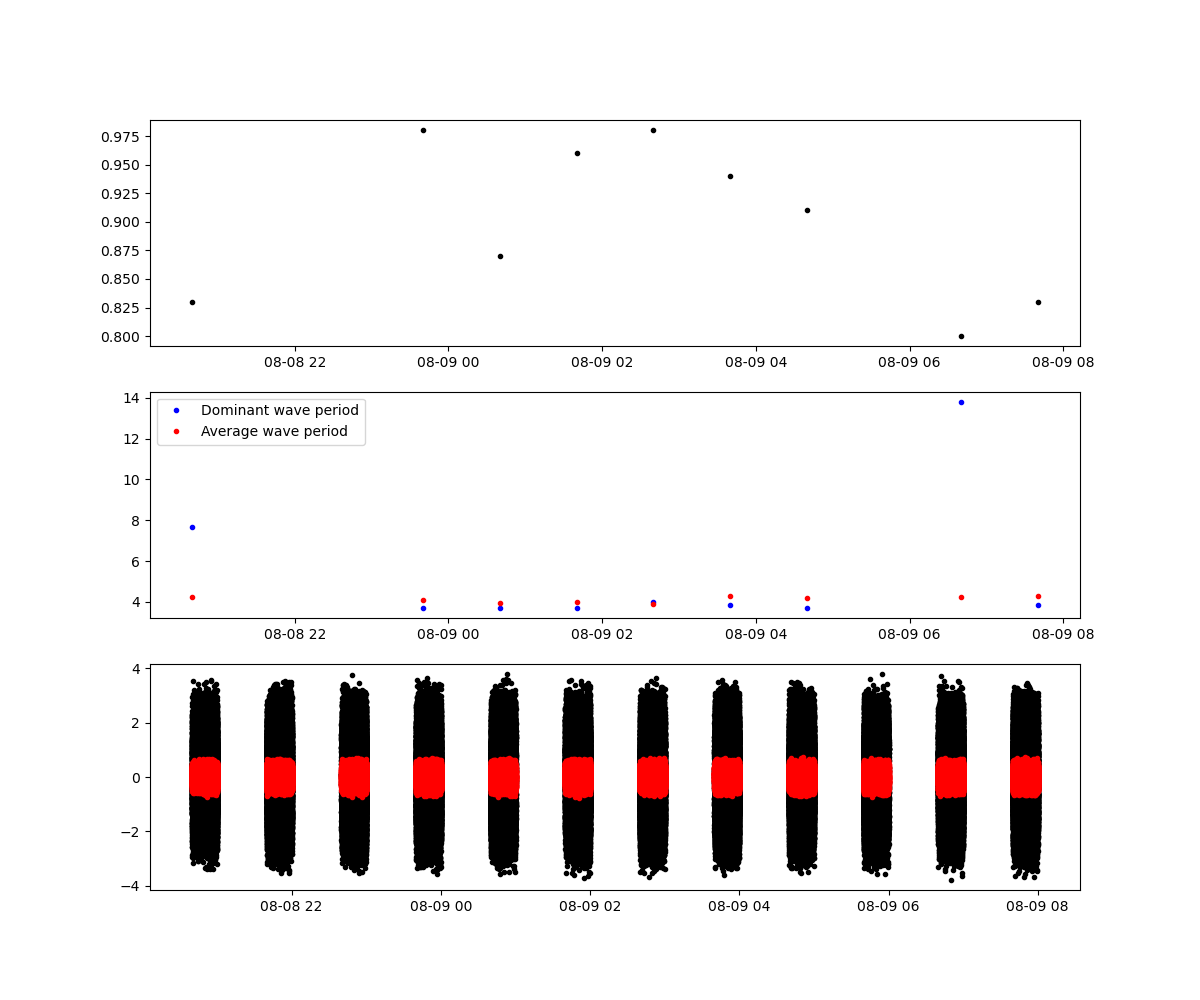

In [48]:
plt.figure(figsize = (12,10))
plt.subplot(311)
plt.plot(ndbc.time, ndbc.WVHT, '.k')
plt.subplot(312)
plt.plot(ndbc.time, ndbc.DPD, '.b', label = 'Dominant wave period')
plt.plot(ndbc.time, ndbc.APD, '.r', label = 'Average wave period')
plt.legend()
plt.subplot(313)
plt.plot(East.time, East, '.k')
plt.plot(Up.time, Up, '.r')

In [59]:
len(Pitch)

14413

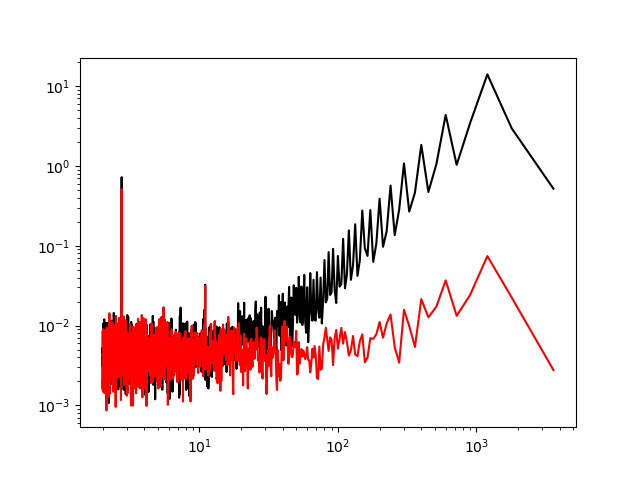

In [63]:
Fp, Sp = welch(Pitch, fs=1, nperseg = len(Pitch)/4, detrend = 'linear')
Fp2, Sp2 = welch(Roll, fs=1, nperseg = len(Roll)/4, detrend = 'linear')
plt.figure()
plt.loglog(1/Fp, Sp, '-k')
plt.loglog(1/Fp2, Sp2, '-r')

In [42]:
#Waves start in deep water (1693m)
wlDeep = 9.8 * 16 / (2 * np.pi) #wavelength in deep water
cDeep = (1/5)*wlDeep
cDeep

4.991099015361839

In [29]:
#Once waves reach our mooring, the depth decreases to 11m
d = 11
wlRatio = d/wlDeep
wlRatio # ratio is .05 > and < .5, so our wave is now intermediate

0.44078468353938416

In [ ]:
wlInt = wlDeep * np.tanh(125.6/x)

In [27]:
x = np.linspace(0,10000, 1000)
y = 

In [4]:
adv1_raw = xr.open_dataset('ADV/adv1_all.nc')
adv2_raw = xr.open_dataset('ADV/adv2_all.nc')

In [16]:
vecDS = adv1_raw.copy(deep=True)
East = vecDS.East.resample(time='20Min').mean().dropna(dim = 'time')
North = vecDS.North.resample(time='20Min').mean().dropna(dim = 'time')
Press = vecDS.Pressure.resample(time='20Min').std().dropna(dim = 'time')

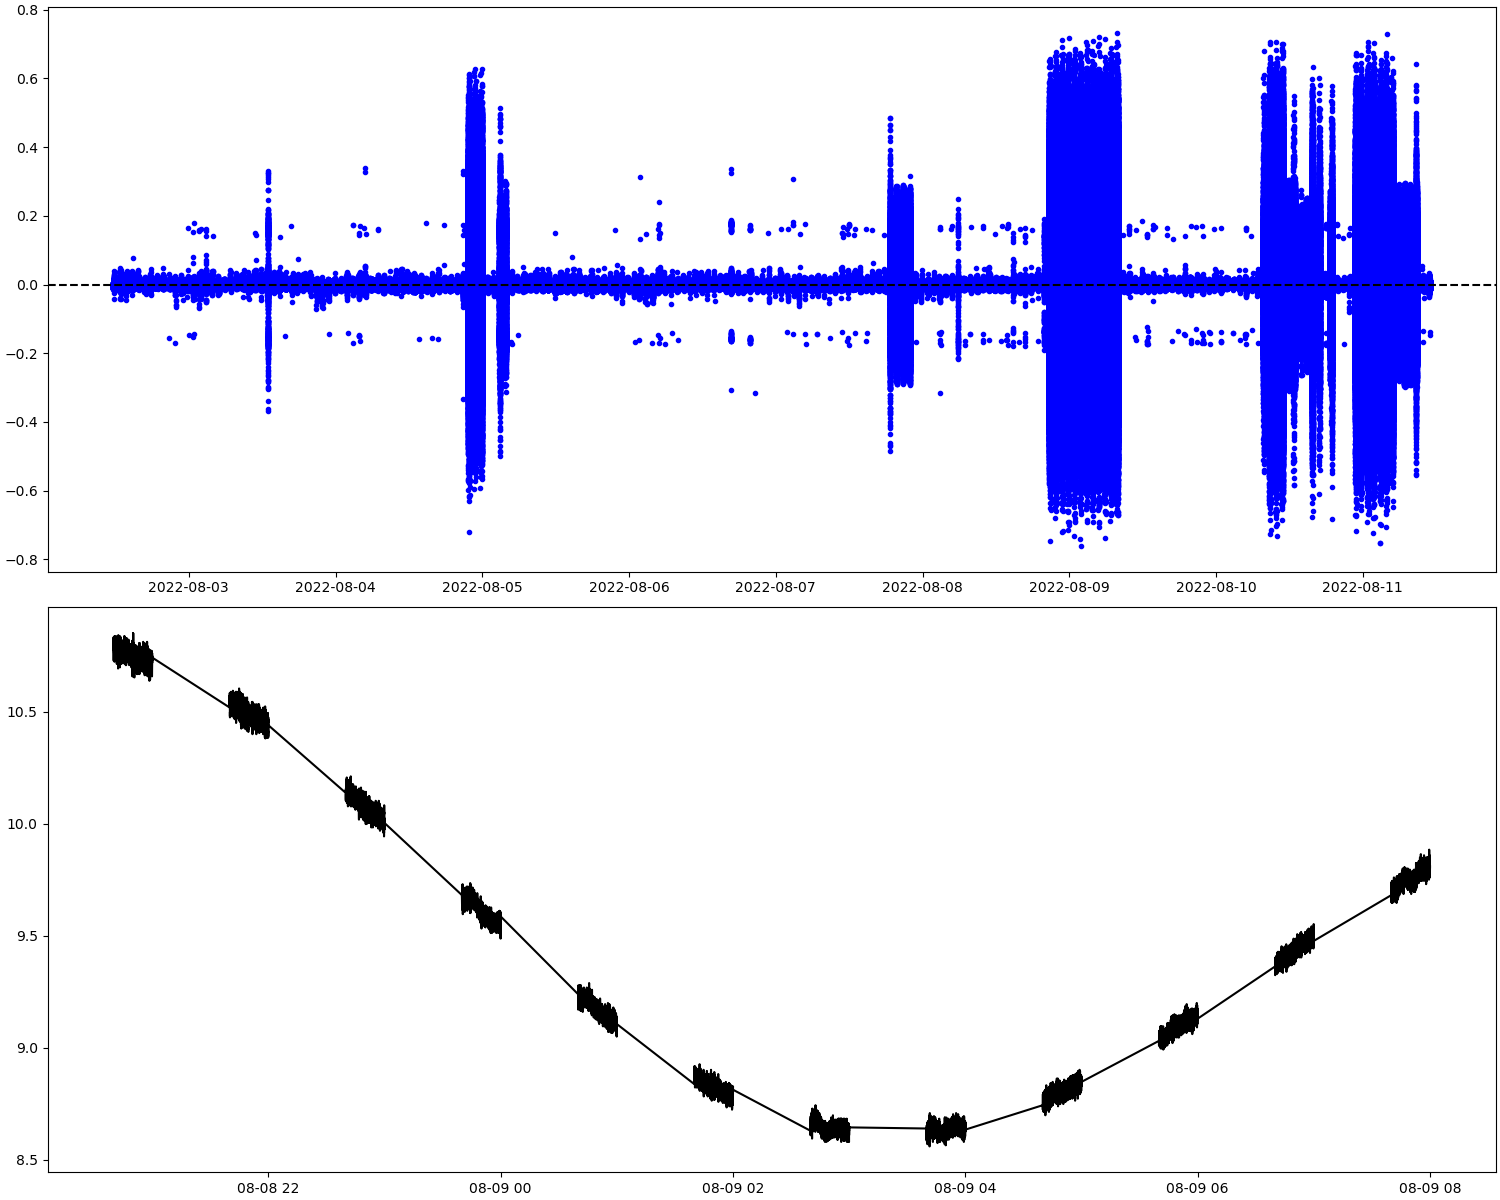

In [50]:
fig, axs = plt.subplots(2,1,constrained_layout=True, figsize = (15,12))
axs[0].plot(adv1_raw.time, adv1_raw.Up, '.b')
axs[0].axhline(y=0, c = 'black', ls = '--')

#axs[1].plot(adv1_raw.time, adv1_raw.North, '.r')
#axs[1].axhline(y=0, c = 'black', ls = '--')

axs[1].plot(Pressure.time, Pressure, '-k')

In [296]:


gb = np.unique(vecDS.burst.where((vecDS.dEast < .25) & (vecDS.dNorth < .25) & (vecDS.burst.isin(vecDS.BurstNum)), drop=True))

East = vecDS.East.resample(time='20Min').mean().dropna(dim = 'time')
eastSTD = vecDS.East.resample(time='20Min').std().dropna(dim = 'time')

North = vecDS.North.resample(time='20Min').mean().dropna(dim = 'time')
northSTD = vecDS.North.resample(time='20Min').std().dropna(dim = 'time')

presSTD = vecDS.Pressure.resample(time='20Min').std().dropna(dim = 'time')

In [ ]:
def sppConversion(Pressure, Rho, fs, nperseg, dBarToPascal = True, ZpOffset = .578, ZvOffset = .824, radianFrequency = True):
    
    if dBarToPascal:
        pressure = Pressure * 10000 #Convert from dBar to Pascals for spectra conversion via linear wave theory
        
    Fp, Sp = welch(pressure, fs = fs, nperseg = nperseg, window='hann', detrend = 'linear') # Pressure spectra
    
    #Convert frequency to radian frequency and wavenumber
    g = 9.8 # Gravity
    z = pressure/(Rho*g) # Depth (m): the recorded pressure converted to meters of seawater
    H = np.mean(z) + ZpOffset # Sea level height (m): mean pressure detected by the pressure sensor plus the height of sensor from the bottom
    Zp = -(np.mean(z)) # Depth of pressure sensor (m)
    Zv = (-H) + ZvOffset # Depth of velocity sensor (m): Sea level height plus the height of the velocity transducers from the bottom
    T = 1/Fp
    omega,k,Cph,Cg = wavedisp(T, H)

    # Generate empty arrays for p' and w' values
    p_prime = np.empty(len(omega))
    w_prime = np.empty(len(omega))

    for j in range(len(omega)): # For loop iterates over all values of omega
        p_prime[j] = (Rho*g)*(np.cosh(k[j]*(Zp+H))/np.cosh(k[j]*H))
        w_prime[j] = (-omega[j])*(np.sinh(k[j]*(Zv+H)))/(np.sinh(k[j]*H))
    scaleFactor = w_prime**2 / p_prime**2
    
    #Calculate the equivalent Sw spectra from Sp
    if radianFrequency:
        Sw_prime = ((Sp/(2*np.pi)) * scaleFactor)
    else:
        Sw_prime = (Sp * scaleFactor)
        
    return Sw_prime

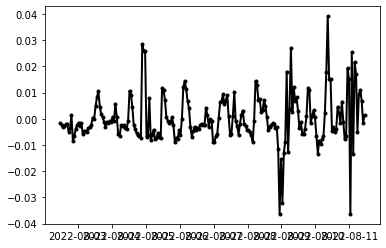

In [332]:
plt.plot(East.time, East, '.-k', lw = 2)

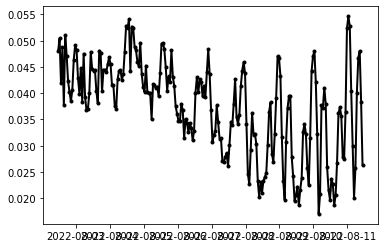

In [297]:
plt.plot(presSTD.time, presSTD, '.-k', lw = 2)

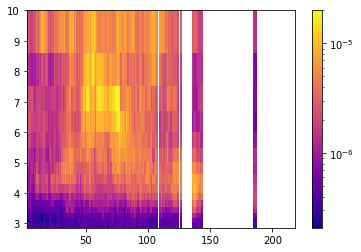

In [331]:
epsDS = eps1
T = (2*np.pi)/epsDS.omega[6:22]
Spp = epsDS.Sp.isel(omega = np.arange(6,22,1))
plt.pcolormesh(epsDS.bNum, T, Spp.T, norm=matplotlib.colors.LogNorm(), cmap = 'plasma')
plt.colorbar()

In [317]:
eps1

<xarray.Dataset>
Dimensions:        (bNum: 155, omega: 961, frequency: 961, wavenumber: 961)
Coordinates:
  * bNum           (bNum) float64 3.0 4.0 5.0 6.0 ... 204.0 205.0 213.0 218.0
  * omega          (omega) float64 0.0 0.1047 0.2094 ... 100.3 100.4 100.5
  * frequency      (frequency) float64 0.0 0.01667 0.03333 ... 15.97 15.98 16.0
  * wavenumber     (wavenumber) float64 nan 0.01072 ... 1.029e+03 1.031e+03
Data variables: (12/30)
    Su             (bNum, omega) float64 ...
    Sv             (bNum, omega) float64 ...
    Sw             (bNum, omega) float64 ...
    Sp             (bNum, omega) float64 ...
    NoiseFloor     (bNum) float64 ...
    WavePeak       (bNum) float64 19.0 19.0 19.0 19.0 ... 204.0 205.0 213.0 20.0
    ...             ...
    epsLRSlopeErr  (bNum) float64 ...
    epsLRIntErr    (bNum) float64 ...
    L_Ozmidov      (bNum) float64 ...
    L_Kolmogorov   (bNum) float64 ...
    dUp            (bNum) float64 ...
    timeStart      (bNum) datetime64[ns] ...
Attributes:
    description:      Turbulent dissipation estimates with associated variables
    nperseg:          1920
    Minimum_gap:      6.283185307179586
    Noise_frequency:  21.991148575128552

In [283]:
#fig, axs = plt.subplots(2,1,constrained_layout=True, figsize = (15,12))



#axs[0].plot(presSTD.time, presSTD)
#axs[1].plot(buoy.time, buoy)

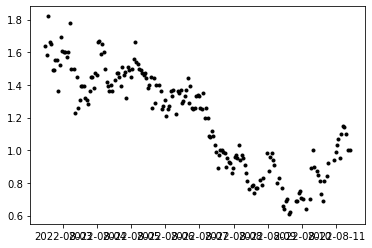

In [299]:

buoy = ndbc_2022.sel(time = slice(presSTD.time[0], presSTD.time[-1]))
plt.plot(buoy.time, buoy.WVHT, '.k')

In [23]:
Feast, Seast = welch(adcp1.EastDA, fs = 1, nperseg = (len(adcp1.EastDA)/8), window = 'hann')
Fnorth, Snorth = welch(adcp1.NorthDA, fs = 1, nperseg = (len(adcp1.NorthDA)/8), window = 'hann')

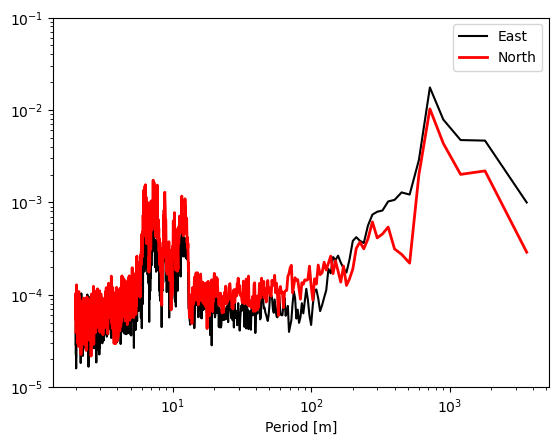

In [24]:
plt.loglog(1/Feast, Seast, '-k', label = 'East')
plt.loglog(1/Fnorth, Snorth, '-r',lw = 2, label = 'North')
#plt.xlabel('Frequency [cpm]')
plt.xlabel('Period [m]')
plt.ylim(10e-6, .1)
plt.legend()

In [43]:
# 1 cpd / 24 cphr * 1cphr / 60 cpm
.1 * 60 *24

144.0

### Turbulent Kintetic Energy Dissipation Rate ($\epsilon$)
- Any velocity measurements with a Signal-to-noise ratio below 10 or a Correlation below 60% on any of the three beams is removed
- ADV data is despiked using an exanding ellipsoid algorithm outlined in Wheeler and Giddings (2023)
- The data gaps created by the quality control and despiking process are then linearly interpolated over gaps <= 1 second, with larger gaps being filled in with the average of the orginal values present within the gap
- These "fixed" data points are labelled as "unoriginal", and a ratio of unoriginal to original data points is recorded for future quality control
- $\epsilon$ is estimated from the vertical velocity spectra of 20-minute ADV bursts with an unoriginal ratio < 0.25
- Each burst was filtered using a Hann window with 60-second segments and 50% overlap resulting in 106 degrees of freedom (Thomson and Emery, 2014)
- Locating the inertial subrange (ISR):
    - Initial boundaries of the ISR were estimated as the peak surface wave frequency (low boundary) and the instrument noise floor (high boundary), which was consistently set at 3.5 Hz
    - To estimate the peak wave frequency, pressure spectra recorded by the ADV was converted to vertical velocity via linear wave theory
    - Within these boundaries, every sequence of points with a minimum range of 1Hz was fit with a power-law curve and a power-law with fixed -5/3 slope, both using least squares error
- Calculating $\epsilon$:
    - $\epsilon(\omega)$ = ${\langle\frac{S_{ww}(\omega) \omega^\frac{5}{3}}{\alpha J_{33}(\omega)}\rangle} ^\frac{3}{2}$
    - $S_{ww}(\omega)$ = Vertical velocity spectra at omega
    - $\omega$ = radian frequency being evaluated
    - $\alpha$ = 1.5 (Kolmogoroff's constant)
    - $J_{33}(\omega)$ = integral over 3D wavenumber space that depends on the mean flow and wave-orbital velocities
    - $\epsilon$ is estimated over all radian frequencies within proposed inertial subrange
- The $\epsilon$ estimates were then run through a series of quality control tests:
    - The intercept of the fit is > standard error in the intercept (Jones and Monosmith, 2008)
    - The average of the noise floor magnitude < half the magnitude of spectrum at lower ISR boundary (Gerbi et al. 2009)
    - The slope ($\mu$) and slope error($\mu_{err}$) of the fit fall within acceptable boundaries:
        - $\mu$ - 2$\mu_{err}$ - .06 < -5/3 < $\mu$ + 2$\mu_{err}$ + .06 (Feddersen, 2010)
        - $\frac{|\mu + \frac{5}{3}|}{\mu_{err}}$ < 1.960 (Wheeler and Giddings, 2023)
    - Linear regression of $\epsilon(\omega)$ over suggested ISR has a slope that is statiscally indistinguishable from 0
- From the suggested ISR ranges that pass all tests, the the fit with the lowest root mean square error from the -5/3 fit was chosen as the best
- From this best fit, the mean of $\epsilon$ over the ISR is calculated and used as the final value of $\epsilon$ for the data burst

In [302]:
# Turbulent dissipation data
eps1 = xr.open_dataset('Dissipation/eps1IntAvg.nc')
eps2 = xr.open_dataset('Dissipation/eps2IntAvg.nc')